In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from imutils import paths
from tqdm import tqdm
from keras.models import load_model
import keras.backend as K
import keras
from scipy.stats import norm
import tensorflow as tf
import matplotlib.animation as animation
from sklearn import metrics 
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from numpy.linalg import svd

import pandas as pd
import random
from sklearn.manifold import TSNE
import seaborn as sns
import glob
from scipy import misc
import sklearn
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import filters
from keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19
import tensorflow_probability as tfp
from functools import partial
from tensorflow_addons.layers import SpectralNormalization
from scipy.linalg import sqrtm
from functools import partial
from random import shuffle
from keras.layers.convolutional import Conv2D, InputSpec
from keras import initializers
from keras.layers import Input, Dense
from matplotlib.patches import Rectangle
import tensorflow_addons as tfa
import scipy.stats as st
from scipy.stats import wasserstein_distance

In [2]:
from platform import python_version
print(python_version())
print(tf.__version__)
print(keras.__version__)
tf.config.list_physical_devices('GPU')

3.9.10
2.6.2
2.6.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import GPUtil
from tabulate import tabulate
gpu = GPUtil.getGPUs()
print(gpu[0].name)

NVIDIA GeForce RTX 3090


In [4]:
class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs    
    
@tf.keras.utils.register_keras_serializable(package='Custom', name='Wvar_reg')
def Wvar_reg(weight_matrix):
    return 50*tf.math.reduce_mean(tf.math.reduce_variance(weight_matrix))

In [5]:
img_rows, img_cols = 64, 64
img_size = 64 
nmax = 5000
data_path = '/home/odedrot' # user input

In [6]:
def sample_images(imgs, r,c):
    fig, axs = plt.subplots(r, c, figsize=(20,2*r))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    
def sample_images_labels(imgs, labels, r, c):
    fig, axs = plt.subplots(r, c, figsize=(20,2*r))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            axs[i,j].set_title(str(labels[cnt]), fontsize=20) # str(cnt) + ' - ' + 
            cnt += 1
    plt.show()

In [7]:
# load data
# margin = 0

def load_images(directory):
    imagePaths = list(paths.list_images(directory))
    data = []
    images_name = []
    i = 1
    for imagePath in imagePaths:
        # images_name.append(imagePath.split("/")[5])
        image = cv2.imread(imagePath) # load the image
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # swap color channels
        # image = image[margin:img_size-margin , margin:img_size-margin] 
        # image = cv2.resize(image, (img_size,img_size) , interpolation = cv2.INTER_AREA)
        data.append(image)
        i = i+1
        if i>nmax:
            break
    req_images = np.array(data)
    req_images =  np.array(req_images).astype("float32")
    req_images = np.expand_dims(req_images, axis=-1)
    return req_images# , images_name

################################################################################################
# test
images = load_images(data_path + '/DISCOVERY-master/IVF/IMAGES/') # ('/home/odedrot/images/Unet_images_64pix_clf_aa_test')
images = images/ 255
print(images.shape)

# true_labels = np.array([np.zeros((images0.shape[0])) , np.ones((images1.shape[0]))]).flatten().astype('uint8')
##################################################################################################

(2, 64, 64, 1)


In [8]:
# check classifier predictions are similar to CLF training

saved_name = 'IVF_CLF_SAVED_MODEL.h5' # new
clf_model_path = data_path + '/DISCOVERY-master/IVF/' + saved_name
clf_model = load_model(clf_model_path , compile=True)

images3D = images.repeat(3, -1)   
images3D_clfscore = clf_model.predict(images3D)



In [9]:
# load models
latent_dim = 350
semantic_dim = 14
model_path = data_path + '/DISCOVERY-master/IVF/IVF_DISCOVER_SAVED_MODELS/'
encoder = load_model(model_path + 'encoder' + '.h5' , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'Wvar_reg': Wvar_reg})
decoder = load_model(model_path + 'generator' + '.h5' , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'Wvar_reg': Wvar_reg})
recognizer = load_model(model_path + 'disentangleNET' + '.h5' , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'Wvar_reg': Wvar_reg})


In [10]:
# encode/decode images
try:
    z_dist, Escore = encoder.predict(images)
except:
    z_dist = encoder.predict(images) 
    

images_recon = decoder.predict(z_dist)
print(z_dist.shape)
latent_dim = z_dist.shape[1]


(2, 350)


In [16]:
images_recon.shape

(2, 64, 64, 1)

real samples


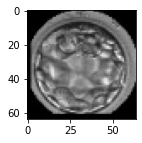

recon samples


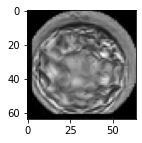

In [21]:
#  reconstruction
ids = range(2)
print('real samples')
plt.figure(figsize=(2,2))
plt.imshow(images[0], cmap='gray')
plt.show()
print('recon samples')
plt.figure(figsize=(2,2))
plt.imshow(images_recon[0], cmap='gray')
plt.show()



0


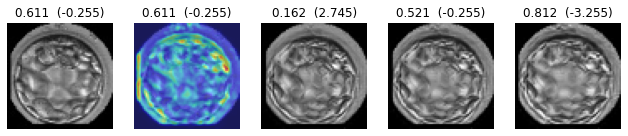

In [31]:

def interpretability(imgs, pert_dim, pert_value, ids):
    
    plus_pert_value  =  pert_value
    minus_pert_value = -pert_value

    test_images_ = imgs # / 255 
    test_images_scores = clf_model( test_images_.repeat(3, -1) )
    test_z_images, test_z_scores  = encoder.predict(test_images_)
    test_recon_images = decoder.predict(test_z_images)
    test_recon_images_scores = clf_model(test_recon_images.repeat(3, -1))


    for idx in ids: # [7,11, 48,25, 9, 27, 39]: # range(200,300): 

        print(idx)

        latent_vec = test_z_images[idx]

        pert_latent_z_plus = np.copy(latent_vec)
        pert_latent_z_plus[pert_dim] = latent_vec[pert_dim] + plus_pert_value 
        pert_recon_img_plus = decoder.predict(np.expand_dims(pert_latent_z_plus, axis=0)) # decoder
        pert_plus_score = np.round(clf_model( pert_recon_img_plus.repeat(3, -1) ).numpy()[0][0],3)


        pert_latent_z_minus = np.copy(latent_vec) 
        pert_latent_z_minus[pert_dim] = latent_vec[pert_dim] + minus_pert_value 
        pert_recon_img_minus = decoder.predict(np.expand_dims(pert_latent_z_minus, axis=0))  # decoder
        pert_minus_score = np.round(clf_model( pert_recon_img_minus.repeat(3, -1) ).numpy()[0][0],3)


        diff_ssim = 1 - ssim(pert_recon_img_minus[0,:,:,0], pert_recon_img_plus[0,:,:,0], win_size=7,     K1=0.03 , K2=0.003,    sigma=0.5 , gradient=True, gaussian_weights = False , full=True)[2] # 1-grad, 2-ssim        
        # diff = pert_recon_img_minus[0,:,:,0] - pert_recon_img_plus[0,:,:,0]
        diff = np.abs(pert_recon_img_minus[0,:,:,0] - pert_recon_img_plus[0,:,:,0])
        diff = cv2.GaussianBlur(diff,(3,3),1) 

        fig, axs = plt.subplots(1, 5, figsize=(11,7))

        axs[0].imshow(test_images_[idx], cmap='gray')
        axs[0].set_title(str(np.round(test_images_scores[idx].numpy()[0],3)) + '  (' + str(np.round(test_z_images[idx][pert_dim],3)) + ')' )
        axs[0].axis('off')

        axs[1].imshow(test_images_[idx], cmap='gray', alpha=0.8)
        axs[1].imshow(diff, alpha=0.5, cmap='jet') #  , vmin=-0.4, vmax=0.4
        axs[1].set_title(str(np.round(test_images_scores[idx].numpy()[0],3)) + '  (' + str(np.round(test_z_images[idx][pert_dim],3)) + ')' )
        axs[1].axis('off')

        axs[2].imshow(pert_recon_img_plus[0], cmap='gray')
        axs[2].set_title(str(pert_plus_score) + '  (' + str(np.round(pert_latent_z_plus[pert_dim],3)) + ')' )
        axs[2].axis('off')

        axs[3].imshow(test_recon_images[idx], cmap='gray')
        axs[3].set_title(str(np.round(test_recon_images_scores[idx].numpy()[0],3)) + '  (' + str(np.round(test_z_images[idx][pert_dim],3)) + ')')
        axs[3].axis('off')

        axs[4].imshow(pert_recon_img_minus[0], cmap='gray')
        axs[4].set_title(str(pert_minus_score) + '  (' + str(np.round(pert_latent_z_minus[pert_dim],3)) + ')')
        axs[4].axis('off')

        plt.show()

pert_dim = 10 
pert_value = 3
ids =  range(0,1) # [7,11, 48,25, 9, 27, 39, 52, 83, 88, 92, 94, 118, 136, 148, 174] # range(200,300)
interpretability(images, pert_dim, pert_value, ids)